In [ ]:
!pip install flash-attn==2.7.3 --no-build-isolation

### Define Structured Data

The first step is to explicitly define the structured data we want to extract from the document. This schema becomes both a validation target and a constraint that helps downstream AI systems remain consistent and auditable.

In [1]:
from typing import List, Literal, Optional
import dotenv
from openai import OpenAI
from pydantic import BaseModel, Field

dotenv.load_dotenv()

client = OpenAI()

class ProductInterest(BaseModel):
    health_insurance: bool = Field()
    dental: bool = Field()
    vision: bool = Field()
    medicare_supplements: bool = Field()
    health_savings_accounts: bool = Field()
    cobra_alternatives: bool = Field()
    rx_plans: bool = Field()
    long_term_care_insurance: bool = Field()
    life_insurance: bool = Field()
    prospect: bool = Field()
    referral: bool = Field()
    referral_text: Optional[str] = Field()

class YouAndFamilyInformation(BaseModel):
    type: Literal["APPLICANT", "SPOUSE", "DEPENDENT"] = Field(description="The type of person. First row of the \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")
    first_name: str = Field(description="Text under FIRST NAME column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")
    initial: str = Field(description="Text under INITIAL column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")
    last_name: str = Field(description="Text under LAST NAME column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")
    height: str = Field(description="Text under HEIGHT column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")
    weight: str = Field(description="Text under WEIGHT column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")
    date_of_birth: str = Field(description="Text under DATE OF BIRTH column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table in YYYY-MM-DD format.")
    sex: Literal["M", "F"] = Field(description="Text under SEX column in \"COMPLETE FOR YOU AND ANY FAMILY MEMBERS INTERESTED IN COVERAGE\" table.")

class ClientInformation(BaseModel):
    name: str = Field(description="The full name of the client from (last / first/ middle).")
    male: bool = Field(description="If box next to Male text is checked, then true; otherwise false.", default=False)
    female: bool = Field(description="If box next to Female text is checked, then true; otherwise false.", default=False)
    date_of_birth: str = Field(description="The date of birth of the client in YYYY-MM-DD format.")
    day_phone_number: Optional[str] = Field(description="The phone number next to \"Phone Number Day:\"")
    eve_phone_number: Optional[str] = Field(description="The phone number next to \"Phone Number Eve:\"")
    cell_phone_number: Optional[str] = Field(description="The phone number next to \"Phone Number Cell:\"")
    martial_status_single: bool = Field(description="If box before Single text is checked, then true; otherwise false.", default=False)
    martial_status_married: bool = Field(description="If box before Married text is checked, then true; otherwise false.", default=False)
    martial_status_family: bool = Field(description="If box before Family text is checked, then true; otherwise false.", default=False)
    email: Optional[str] = Field(description="The email address of the client.")

class MedicalHistoryItem(BaseModel):
    person_affected: str = Field(description="The text under \"PERSON AFFECTED\" column value in the MEDICAL HISTORY table.")
    condition_diagnosis: str = Field(description="The text under \"CONDITION / DIAGNOSIS\" column value in the MEDICAL HISTORY table.")
    treatments: Optional[str] = Field(description="The text under \"TREATMENTS\n (SURGERIES/MEDICATIONS)\" column value in the MEDICAL HISTORY table.")
    treatment_dates: Optional[str] = Field(description="The text under \"TREATMENT DATES\n FROM / TO\" column value in the MEDICAL HISTORY table.")
    current_status: Optional[str] = Field(description="The text under \"CURRENT STATUS\n (ONGOING/RESOLVED)\" column value in the MEDICAL HISTORY table.")

class TypeOfCoverage(BaseModel):
    group_plan: bool = Field(description="If box to the left of \"Group Plan\" is checked, then true; otherwise false.")
    individual_plan: bool = Field(description="If box to the left of \"Individual\" is checked, then true; otherwise false.")
    cobra: bool = Field(description="If box to the left of \"COBRA\" is checked, then true; otherwise false.")
    monthly_premium: Optional[str] = Field(description="The text after to \"Monthly Premium:\".")

class CurrentHealthCoverage(BaseModel):
    yes: bool = Field(description="If box left of YES text is checked after the \"Do you currently have a health insurance policy inforce?\", then true; otherwise false.")
    no: bool = Field(description="If box left of NO text is checked after the \"Do you currently have a health insurance policy inforce?\", then true; otherwise false.")
    name_of_insurance_company: Optional[str] = Field(description="The name of the insurance company if YES is checked next to \"please provide name of other insurance company:\".")
    type_of_coverage: TypeOfCoverage

class DocumentAIFields(BaseModel):
    date: str = Field(description="The date of the document in YYYY-MM-DD format.")
    product_interest: ProductInterest
    client_information: ClientInformation
    you_and_family_information: List[YouAndFamilyInformation]
    medical_history: List[MedicalHistoryItem]
    current_health_coverage: CurrentHealthCoverage
    comments: Optional[str] = Field(description="The text under Comments: at the bottom of the document.")

### Test Data

Part of what many AI implementations overlook is the importance of validated test data. Without a known set of correct answers, it’s impossible to measure accuracy or determine whether improvements are meaningful.

In [2]:
from difflib import SequenceMatcher
from typing import Tuple

test_data = [
    {
    'file': 'johnsmith.pdf',
    'expected_output': 
    DocumentAIFields(
        date="2026-01-01",
        product_interest=ProductInterest(
            health_insurance=False,
            dental=False,
            cobra_alternatives=False,
            rx_plans=False,
            vision=False,
            medicare_supplements=False,
            health_savings_accounts=True,
            long_term_care_insurance=False,
            life_insurance=True,
            prospect=True,
            referral=True,
            referral_text="Jane Johnson"
        ),
        client_information=ClientInformation(
            name="John Smith",
            male=True,
            female=False,
            date_of_birth="1990-09-17",
            day_phone_number="555-111-1234",
            eve_phone_number=None,
            cell_phone_number=None,
            martial_status_single=True,
            martial_status_married=False,
            martial_status_family=False,
            email="j.smith8@gmail.com"
        ),
        you_and_family_information=[
            YouAndFamilyInformation(
                type="APPLICANT",
                first_name="John",
                initial="M",
                last_name="Smith",
                height="5'10\"",
                weight="210 lbs",
                date_of_birth="1990-09-17",
                sex="M"
            ),
            YouAndFamilyInformation(
                type="SPOUSE",
                first_name="Liz",
                initial="Q",
                last_name="Smith",
                height="5'3\"",
                weight="154 lbs",
                date_of_birth="1992-09-10",
                sex="F"
            ),
            YouAndFamilyInformation(
                type="DEPENDENT",
                first_name="Bingo",
                initial="B",
                last_name="Smith",
                height="2'2\"",
                weight="50 lbs",
                date_of_birth="2025-12-15",
                sex="M"
            )
        ],
        medical_history=[
            MedicalHistoryItem(
                person_affected="John Smith",
                condition_diagnosis="High Blood Pressure",
                treatments=None,
                treatment_dates="2024-12-12",
                current_status=None
            )
        ],
        current_health_coverage=CurrentHealthCoverage(
            yes=False,
            no=True,
            name_of_insurance_company=None,
            type_of_coverage=TypeOfCoverage(
                group_plan=False,
                individual_plan=False,
                cobra=True,
                monthly_premium=None
            )
        ),
        comments="",
    )
    },
    {
    'file': 'jaime.pdf',
    'expected_output':
    DocumentAIFields(
        date="2025-12-10",
        product_interest=ProductInterest(
            health_insurance=False,
            dental=True,
            vision=False,
            cobra_alternatives=False,
            rx_plans=False,
            medicare_supplements=False,
            health_savings_accounts=False,
            long_term_care_insurance=False,
            life_insurance=False,
            prospect=False,
            referral=False,
            referral_text=None
        ),
        client_information=ClientInformation(
            name="Jaime O'hulihan",
            male=False,
            female=True,
            date_of_birth="1995-01-12",
            day_phone_number=None,
            eve_phone_number=None,
            cell_phone_number="511-555-1111",
            martial_status_single=True,
            martial_status_married=False,
            martial_status_family=False,
            email="jaime.o@hotmail.com"
        ),
        you_and_family_information=[
            YouAndFamilyInformation(
                type="APPLICANT",
                first_name="Jaime",
                initial="",
                last_name="O'hulihan",
                height="56in",
                weight="120 lbs",
                date_of_birth="1995-01-12",
                sex="F"
            )
        ],
        medical_history=[
            MedicalHistoryItem(
                person_affected="Jaime O'hulihan",
                condition_diagnosis="Impacted Molar",
                treatments="Braces",
                treatment_dates="2008-2010",
                current_status="No braces"
            )
        ],
        current_health_coverage=CurrentHealthCoverage(
            yes=False,
            no=True,
            name_of_insurance_company=None,
            type_of_coverage=TypeOfCoverage(
                group_plan=False,
                individual_plan=True,
                cobra=False,
                monthly_premium=None
            )
        ),
        comments="",
    )
    },
    {
        'file': 'larry.pdf',
        'expected_output':
    DocumentAIFields(
        date="2025-03-09",
        product_interest=ProductInterest(
            health_insurance=False,
            dental=False,
            vision=False,
            cobra_alternatives=True,
            rx_plans=False,
            medicare_supplements=True,
            health_savings_accounts=False,
            long_term_care_insurance=False,
            life_insurance=False,
            prospect=False,
            referral=False,
            referral_text=None
        ),
        client_information=ClientInformation(
            name="Larry Adam David",
            male=True,
            female=False,
            date_of_birth="1995-10-19",
            day_phone_number="443-444-3333",
            eve_phone_number="555-123-9999",
            cell_phone_number="663-998-8888",
            martial_status_single=False,
            martial_status_married=True,
            martial_status_family=False,
            email="notlarrydavid@gmail.com"
        ),
        you_and_family_information=[
            YouAndFamilyInformation(
                type="APPLICANT",
                first_name="Larry",
                initial="A",
                last_name="David",
                height="6'3\"",
                weight="190 lbs",
                date_of_birth="1985-10-19",
                sex="M"
            ),
            YouAndFamilyInformation(
                type="SPOUSE",
                first_name="Susan",
                initial="M",
                last_name="David",
                height="5'5\"",
                weight="160 lbs",
                date_of_birth="1992-10-04",
                sex="F"
            ),
        ],
        medical_history=[
            MedicalHistoryItem(
                person_affected="Larry David",
                condition_diagnosis="Cancer",
                treatments="Chemotherapy",
                treatment_dates="2013-2014",
                current_status="In remission"
            )
        ],
        current_health_coverage=CurrentHealthCoverage(
            yes=False,
            no=True,
            name_of_insurance_company=None,
            type_of_coverage=TypeOfCoverage(
                group_plan=False,
                individual_plan=True,
                cobra=True,
                monthly_premium="$900"
            )
        ),
        comments="I have no comment.",
    )
    },
    {
        'file': 'julie.pdf',
        'expected_output':
    DocumentAIFields(
        date="2025-09-04",
        product_interest=ProductInterest(
            health_insurance=True,
            dental=False,
            vision=False,
            cobra_alternatives=False,
            rx_plans=False,
            medicare_supplements=False,
            health_savings_accounts=False,
            long_term_care_insurance=False,
            life_insurance=False,
            prospect=False,
            referral=True,
            referral_text="John Smith"
        ),
        client_information=ClientInformation(
            name="Adams Julie Marie",
            male=False,
            female=True,
            date_of_birth="1993-08-14",
            day_phone_number=None,
            eve_phone_number=None,
            cell_phone_number="444-123-8473",
            martial_status_single=False,
            martial_status_married=False,
            martial_status_family=True,
            email="jadams9816@comcast.net"
        ),
        you_and_family_information=[
            YouAndFamilyInformation(
                type="APPLICANT",
                first_name="Julie",
                initial="M",
                last_name="Adams",
                height="5'7\"",
                weight="195 lbs",
                date_of_birth="1993-08-14",
                sex="F"
            ),
            YouAndFamilyInformation(
                type="SPOUSE",
                first_name="Daniel",
                initial="E",
                last_name="Adams",
                height="5'8\"",
                weight="215 lbs",
                date_of_birth="1994-09-27",
                sex="M"
            ),
            YouAndFamilyInformation(
                type="DEPENDENT",
                first_name="Bob",
                initial="L",
                last_name="Adams",
                height="3'4\"",
                weight="30 lbs",
                date_of_birth="2020-03-14",
                sex="M"
            )
        ],
        medical_history=[
            MedicalHistoryItem(
                person_affected="Julie Adams",
                condition_diagnosis="Insomnia",
                treatments=None,
                treatment_dates=None,
                current_status=None
            ),
            MedicalHistoryItem(
                person_affected="Bob Adams",
                condition_diagnosis="Asthma",
                treatments="Inhaler",
                treatment_dates="Current",
                current_status="Current"
            )
        ],
        current_health_coverage=CurrentHealthCoverage(
            yes=True,
            no=False,
            name_of_insurance_company="BCBS of CT",
            type_of_coverage=TypeOfCoverage(
                group_plan=True,
                individual_plan=False,
                cobra=False,
                monthly_premium="$2100"
            )
        ),
        comments="Looking to lower my monthly premium"
    )
    },
]

def compare_document_ai_fields(obj1: DocumentAIFields, obj2: DocumentAIFields) -> Tuple[float, float]:
    def compare_strings(str1: Optional[str], str2: Optional[str]) -> float:
        if (str1 == None or str1 == "") and (str2 == None or str2 == ""):
            return 1.0
        if str1 is None or str2 is None:
            return 0.0 if str1 != str2 else 1.0
        return SequenceMatcher(None, str1, str2).ratio()

    def compare_booleans(bool1: bool, bool2: bool) -> float:
        return 1.0 if bool1 == bool2 else 0.0

    def compare_lists(list1: List, list2: List, compare_func) -> float:
        if len(list1) != len(list2):
            return 0.0
        return sum(compare_func(item1, item2) for item1, item2 in zip(list1, list2)) / len(list1)

    def compare_product_interest(pi1: ProductInterest, pi2: ProductInterest) -> float:
        fields = vars(pi1).keys()
        return (
            (sum(
            compare_booleans(getattr(pi1, field), getattr(pi2, field))
            for field in fields if field != "referral_text"
            )
        ) + compare_strings(pi1.referral_text, pi2.referral_text)) / len(fields)
    

    def compare_client_information(ci1: ClientInformation, ci2: ClientInformation) -> float:
        fields = vars(ci1).keys()
        return sum(
            compare_strings(getattr(ci1, field), getattr(ci2, field)) if isinstance(getattr(ci1, field), str) else compare_booleans(getattr(ci1, field), getattr(ci2, field))
            for field in fields
        ) / len(fields)

    def compare_you_and_family_information(yfi1: YouAndFamilyInformation, yfi2: YouAndFamilyInformation) -> float:
        fields = vars(yfi1).keys()
        return sum(
            compare_strings(getattr(yfi1, field), getattr(yfi2, field)) if isinstance(getattr(yfi1, field), str) else compare_booleans(getattr(yfi1, field), getattr(yfi2, field))
            for field in fields
        ) / len(fields)

    def compare_medical_history_item(mh1: MedicalHistoryItem, mh2: MedicalHistoryItem) -> float:
        fields = vars(mh1).keys()
        return sum(
            compare_strings(getattr(mh1, field), getattr(mh2, field)) if isinstance(getattr(mh1, field), str) else compare_booleans(getattr(mh1, field), getattr(mh2, field))
            for field in fields
        ) / len(fields)

    def compare_type_of_coverage(tc1: TypeOfCoverage, tc2: TypeOfCoverage) -> float:
        fields = vars(tc1).keys()
        return sum(
            compare_strings(getattr(tc1, field), getattr(tc2, field)) if isinstance(getattr(tc1, field), str) else compare_booleans(getattr(tc1, field), getattr(tc2, field))
            for field in fields
        ) / len(fields)

    def compare_current_health_coverage(chc1: CurrentHealthCoverage, chc2: CurrentHealthCoverage) -> float:
        fields = vars(chc1).keys()
        return sum(
            compare_strings(getattr(chc1, field), getattr(chc2, field)) if isinstance(getattr(chc1, field), str) else compare_booleans(getattr(chc1, field), getattr(chc2, field))
            for field in fields if field != "type_of_coverage"
        ) / (len(fields) - 1) + compare_type_of_coverage(chc1.type_of_coverage, chc2.type_of_coverage)

    product_interest_score = compare_product_interest(obj1.product_interest, obj2.product_interest)

    total_score = (
        compare_strings(obj1.date, obj2.date) +
        compare_product_interest(obj1.product_interest, obj2.product_interest) +
        compare_client_information(obj1.client_information, obj2.client_information) +
        compare_lists(obj1.you_and_family_information, obj2.you_and_family_information, compare_you_and_family_information) +
        compare_lists(obj1.medical_history, obj2.medical_history, compare_medical_history_item) +
        compare_current_health_coverage(obj1.current_health_coverage, obj2.current_health_coverage) +
        compare_strings(obj1.comments, obj2.comments)
    )

    # Returning both product interest score and overall score as we're interested in both aspects
    return (product_interest_score * 100, (total_score / 8) * 100)



### OpenAI GPT-5.2 Alone

It's not a bad idea to see what AI is capable of without assistance. This establishes a baseline, but it also highlights where AI struggles without structural guidance—especially in visually ambiguous elements.

**COST NOTE:** At the time of creating and testing this, the 4 requests cost $0.04. There were 10.612K Input Tokens and 1.608K Output Tokens

In [3]:
from pathlib import Path

def ocr_scanned_pdf_to_fields(pdf_path: str) -> "DocumentAIFields":
    # in productizing this, we'd cache uploads to avoid re-uploading the same file
    with open(pdf_path, "rb") as f:
        uploaded = client.files.create(file=f, purpose="user_data") 

    prompt = """
Extract fields from this scanned insurance form.
Return ONLY JSON matching the schema.
Rules:
- Dates => YYYY-MM-DD.
- Unchecked boxes => false.
- If blank/unknown: Optional => null; required string cells in tables => "".
- Tables: one object per filled row.
"""

    resp = client.responses.parse(
        model="gpt-5.2",
        input=[{
            "role": "user",
            "content": [
                {"type": "input_file", "file_id": uploaded.id},
                {"type": "input_text", "text": prompt},
            ],
        }],
        text_format=DocumentAIFields,
        store=True
    )


    return DocumentAIFields.model_validate_json(resp.output_text)

for test_case in test_data:
    file_path = f"./docs/{test_case['file']}"
    expected_output = test_case['expected_output']

    print(f"Processing file: {file_path}")
    extracted_fields = ocr_scanned_pdf_to_fields(file_path)

    output_file = Path(f"./results/gpt5.2/{Path(file_path).stem}_extracted.json")
    output_file.parent.mkdir(parents=True, exist_ok=True)
    output_file.write_text(extracted_fields.model_dump_json(indent=2))

    similarity_product_interest, overall_similarity = compare_document_ai_fields(extracted_fields, expected_output)
    print(f"Similarity to expected output: {overall_similarity:.2f}%")
    print(f"Similarity to expected output (Product Interest): {similarity_product_interest:.2f}%")

Processing file: ./docs/johnsmith.pdf
Similarity to expected output: 95.91%
Similarity to expected output (Product Interest): 83.33%
Processing file: ./docs/jaime.pdf
Similarity to expected output: 96.49%
Similarity to expected output (Product Interest): 91.67%
Processing file: ./docs/larry.pdf
Similarity to expected output: 95.04%
Similarity to expected output (Product Interest): 91.67%
Processing file: ./docs/julie.pdf
Similarity to expected output: 98.11%
Similarity to expected output (Product Interest): 100.00%


### 100% AI Solution Results

While the results were impressive for a purely AI-driven approach, they still fell short of the accuracy required for reliable production use. "Product Interest" would be a section the business wants to get correct nearly 100% of time otherwise they're potentially money on the table, or contacting about a product they actually have no interest in.

### Context is King

In almost every case, AI can be improved by providing it with context. This is seen in popular frameworks such as RAG where the context is dynamically retrieved, and is provided to the LLM. What's coming up is similar, but just with information pulled via tranditional methods rather than a document.

### The Pairing of AI and Traditional Engineering

Traditional approaches relied entirely on CV and OCR, while modern systems benefit from using these techniques to provide structured context that allows AI models to reason more effectively.

In [4]:
import cv2

# Load the image using OpenCV
image_cv2 = cv2.imread('./docs/julie.jpg')

# Check if the image was loaded successfully
if image_cv2 is not None:
    print("Image loaded successfully.")
else:
    print("Failed to load the image.")

Image loaded successfully.


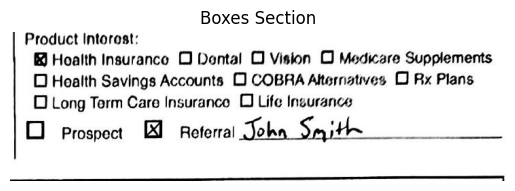

In [5]:
boxes_section = image_cv2[300:520,820:1550]  # Adjust these coordinates as needed

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(boxes_section, cv2.COLOR_BGR2RGB))
plt.title("Boxes Section")
plt.axis("off")
plt.show()

### Traditional CV2 + OCR

Below is how I solved the problem of identifying the squares, identifying whether they were checked or not, and pulling the label context. Note that the context width size is purposefully larger than what is needed, because in the end, context is king. We know with the labels to the right, the text closest to the beginning of the string is most important when associating it with the field name.

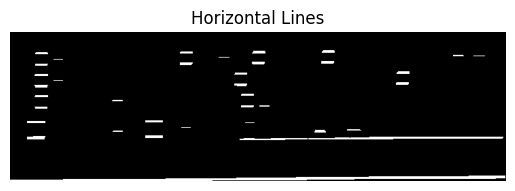

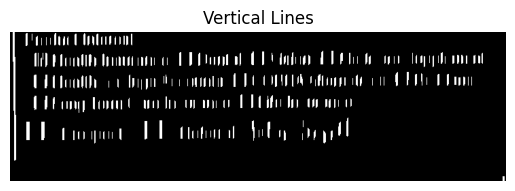

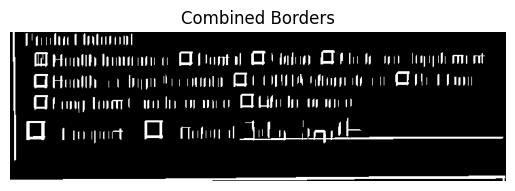

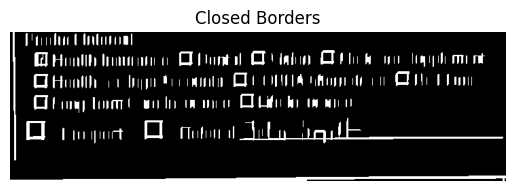

Detected 11 boxes.


In [6]:
from enum import Enum
import cv2
import pytesseract

# Isolates horizontal and vertical lines to find boxes in the image
# NOTE: This is tuned for my sample images; you may need to adjust parameters for your use case.
def find_boxes_by_lines(
    bgr,
    min_w=15,
    min_h=15,
    max_w=None,
    max_h=None,
    aspect_tol=0.35,          # if squares: 0.35 => accept 0.65..1.35 aspect
    rectangularity_min=0.50,  # contour_area / (w*h)
    line_scale=0.02,           # kernel length as fraction of image dim
    show_steps=False
):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # 1) Binarize (invert so ink=1)
    bin_img = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31, 7
    )

    h, w = bin_img.shape[:2]
    if max_w is None: max_w = w
    if max_h is None: max_h = h

    # 2) Extract horizontal/vertical strokes only
    # Kernel lengths should be a bit smaller than typical box side length.
    kx = max(10, int(w * line_scale))
    ky = max(10, int(h * line_scale))

    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kx, 1))
    vert_kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (1, ky))

    horizontal = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, horiz_kernel, iterations=1)

    if show_steps:
        plt.imshow(horizontal, cmap='gray')
        plt.title("Horizontal Lines")
        plt.axis("off")
        plt.show()

    vertical   = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, vert_kernel, iterations=1)
    if show_steps:
        plt.imshow(vertical, cmap='gray')
        plt.title("Vertical Lines")
        plt.axis("off")
        plt.show()

    # 3) Combine to get box borders (ignores diagonals)
    borders = cv2.bitwise_or(horizontal, vertical)

    if show_steps:
        plt.imshow(borders, cmap='gray')
        plt.title("Combined Borders")
        plt.axis("off")
        plt.show()

    # 4) Connect small gaps in borders (broken print / noise)
    borders = cv2.morphologyEx(
        borders,
        cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
        iterations=1
    )

    if show_steps:
        plt.imshow(borders, cmap='gray')
        plt.title("Closed Borders")
        plt.axis("off")
        plt.show()

    # Optional: slightly thicken so contours are continuous
    borders = cv2.dilate(borders, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=1)

    # 5) Find contours on borders-only image
    contours, _ = cv2.findContours(borders, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)

        if bw < min_w or bh < min_h or bw > max_w or bh > max_h:
            continue

        # If you only want squares, keep this. If you want rectangles too, remove it.
        aspect = bw / float(bh)
        if not (1 - aspect_tol <= aspect <= 1 + aspect_tol):
            continue


        # Rectangularity filter: boxes look like rectangles; scribbles don't.
        area = cv2.contourArea(cnt)
        rect_area = bw * bh
        if rect_area <= 0:
            continue

        rectangularity = area / float(rect_area)
        if rectangularity < rectangularity_min:
            continue

        # Stronger geometry test: approx polygon should be 4-ish corners
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) < 4:
            continue

        boxes.append((x, y, bw, bh))

    boxes.sort(key=lambda b: (b[1], b[0]))
    return boxes, bin_img, borders

class ContextDirection(Enum):
    LEFT = 1
    RIGHT = 2
    UP = 3
    DOWN = 4

def get_box_context(section, box, context_dir: ContextDirection, outer_pixel_count=5, context_size=200, box_checked_threshold=0.4):
    x, y, w, h = box
    h_img, w_img = section.shape[:2]

    def is_box_checked(box, section, threshold=0.4):
        x, y, w, h = box
        x0 = max(0, x + outer_pixel_count)
        y0 = max(0, y + outer_pixel_count)
        x1 = min(w_img, x + w - outer_pixel_count)
        y1 = min(h_img, y + h - outer_pixel_count)

        box_area = section[y0:y1, x0:x1]

        total_pixels = box_area.size
        black_and_white = cv2.cvtColor(box_area, cv2.COLOR_BGR2GRAY)
        _, binary_box = cv2.threshold(black_and_white, 200, 255, cv2.THRESH_BINARY_INV)
        black_pixels = cv2.countNonZero(binary_box)

        black_fraction = black_pixels / total_pixels
        return black_fraction >= threshold

    is_checked = is_box_checked(box, section, threshold=box_checked_threshold)

    context_text = ""

    if context_dir == ContextDirection.LEFT:
        context_img = section[y-5:y+h+5, max(0, x-context_size):x]
        
    if context_dir == ContextDirection.RIGHT:
        context_img=section[y-5:y+h+5, x+ w : min(w_img, x + w + context_size)]
    if context_dir == ContextDirection.UP:
        context_img = section[max(0, y - context_size):y, x:x+w]
    if context_dir == ContextDirection.DOWN:
        context_img = section[y + h : min(h_img, y + h + context_size), x:x+w]

    context_text = pytesseract.image_to_string(context_img)
    return (is_checked, context_text.strip())

    
boxes, bin_img, borders = find_boxes_by_lines(boxes_section, show_steps=True)

print(f"Detected {len(boxes)} boxes.")

contexts = []

def get_checkboxes_and_contexts(section, box_checked_threshold=0.18):
    boxes, _, _ = find_boxes_by_lines(section)
    context = ""
    for box in boxes:
        is_checked, context_text = get_box_context(section, box, ContextDirection.RIGHT, context_size=300, box_checked_threshold=box_checked_threshold)
        context += f"{'checked' if is_checked else 'unchecked'}: {context_text}\n"
    return context

for box in boxes:
    contexts.append(get_box_context(boxes_section, box, ContextDirection.RIGHT, context_size=300, box_checked_threshold=0.2))

### AI + CV2/OCR Context

Now we have the ability to pull checkbox values more accurately so we'll provide that as context to the overall parsing of the document.

**COST NOTE:** At the time of creating and testing this, the 4 requests cost $0.04. There were 11.269K Input Tokens and 2.119K Output Tokens

In [7]:
from pathlib import Path
from pdf2image import convert_from_path

class DocumentContext(BaseModel):
    section_name: str = Field(description="The name of the section where context is being provided")
    context: str = Field(description="Context")
    additional_instructions: Optional[str] = Field(description="Any additional instructions for interpreting the context")

def ocr_scanned_pdf_to_fields_with_contexts(pdf_path: str, contexts: Optional[list[DocumentContext]] = None) -> "DocumentAIFields":
    # Upload once, reuse file_id if you want
    with open(pdf_path, "rb") as f:
        uploaded = client.files.create(file=f, purpose="user_data")

    prompt = """
Extract fields from this scanned insurance form.
Return ONLY JSON matching the schema.
Use the provided context to help interpret the document.
Rules:
- Dates => YYYY-MM-DD.
- Unchecked boxes => false.
- If blank/unknown: Optional => null; required string cells in tables => "".
- Tables: one object per filled row.
"""

    if contexts:
        for context in contexts:
            prompt += f"\nContext for section '{context.section_name}': {context.context}"
            if context.additional_instructions:
                prompt += f" Additional instructions: {context.additional_instructions}"

    resp = client.responses.parse(
        model="gpt-5.2",
        input=[{
            "role": "user",
            "content": [
                {"type": "input_file", "file_id": uploaded.id},
                {"type": "input_text", "text": prompt},
            ],
        }],
        text_format=DocumentAIFields,
        store=True
    )


    return DocumentAIFields.model_validate_json(resp.output_text)

for test_case in test_data:
    file_path = f"./docs/{test_case['file']}"
    expected_output = test_case['expected_output']

    print(f"Processing file: {file_path}")
    # Convert PDF to JPG using pdf2image
    images = convert_from_path(file_path)

    # Save the first page as a JPG
    image_path = f"./docs/{Path(file_path).stem}.jpg"
    images[0].save(image_path, "JPEG")

    # Load the image using OpenCV
    image_cv2 = cv2.imread(image_path)
    boxes_section = image_cv2[300:520,820:1550]  # Adjust these coordinates as needed

    product_interest_context = get_checkboxes_and_contexts(boxes_section)

    print(product_interest_context)

    extracted_fields = ocr_scanned_pdf_to_fields_with_contexts(file_path, contexts=[
        DocumentContext(
            section_name="Product Interest",
            context=product_interest_context,
            additional_instructions="The first part determines if the box is checked (or if the bool should be true) and the second part is OCR context to the right of the box. It may be incorrect, and may have more or less text than needed, but emphasize the earliest parts in choosing what field this maps to."
        )
    ])

    similarity_product_interest, overall_similarity = compare_document_ai_fields(extracted_fields, expected_output)
    print(f"Similarity to expected output: {overall_similarity:.2f}%\n")
    print(f"Similarity to expected output (Product Interest): {similarity_product_interest:.2f}%\n")

Processing file: ./docs/johnsmith.pdf
unchecked: Medicare Supplement
unchecked: Vision 0 Medicare Supplem
unchecked: Health Insurance C1 Dental
unchecked: Dontal 01 Vision 0 Medica
unchecked: Rx Plans
unchecked: COBRA Alternatives 0 Rx P
checked: Hoalth Savings Accounts
checked: Life Ingurance
unchecked: Long Torm Caro Insurance &
checked: Referral Jane Jonns
checked: Prospect Bd Rotersal

Similarity to expected output: 95.61%

Similarity to expected output (Product Interest): 100.00%

Processing file: ./docs/jaime.pdf
unchecked: Medicare Supplements
checked: Qontal O Vision O Medicare
unchecked: Vision CO Medicare Suppleme
unchecked: Hoalth Insurance Bd Dantal |
unchecked: Rx Plans
unchecked: COBRA Alternatives 0 Rx Pl
unchecked: Hoalth Savings Accounts
unchecked: life Ingurance
unchecked: Long Torm Caro Insurances (2
unchecked: Roferral
unchecked: Prospect O Roterral

Similarity to expected output: 97.72%

Similarity to expected output (Product Interest): 100.00%

Processing file: ./

## Conclusion

AI is non-deterministic, so these values may change. The following accuracy changes are as of testing this and subject to change if ran by others.

Note that after providing context the Product Interest similarity increased to 100% for all documents.

| Doc | AI Only Full Similarity | AI Only Product Interest Similarity | AI + Context Full Similarity | AI + Context Product Interest Similarity | Full Similarity Increase | Product Interest Increase | 
| --- | ----------------------- | ----------------------------------- | ---------------------------- | ---------------------------------------- | ------------------------ | ------------------------- |
| ./docs/johnsmith.pdf | 95.91% | 83.33% | 95.61% | 100% | -0.3 | +16.67 | 
| ./docs/jaime.pdf | 96.49% | 91.67% | 97.72% | 100% | +1.23 | +2.28 |
| ./docs/larry.pdf | 95.04% | 91.67% | 96.09% | 100% | +1.05 | +3.91 |
| ./docs/julie.pdf | 98.11% | 100.00% | 98.00% | 100% | -0.11 | 0 |
